In [1]:
!python -m pip install --index-url https://support.bayesfusion.com/pysmile-A/ pysmile

Looking in indexes: https://support.bayesfusion.com/pysmile-A/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 207 kB/s 


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.special import expit
import itertools
import pysmile

In [35]:
pysmile.License((
	b"SMILE LICENSE 809da930 df31fca2 70cfb3dc "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: 9wycnvvmtgqhchs8tpfu71dkq "
	b"Issued for: Jaime Perez (jaime.perez.sanchez@gmail.com) "
	b"Academic institution: Universidad Pontificia Comillas "
	b"Valid until: 2023-03-16 "
	b"Issued by BayesFusion activation server"
	),[
	0xcb,0x90,0x44,0xb9,0x6c,0x57,0xfa,0x97,0xd5,0x13,0xc4,0x9f,0x19,0x83,0x8c,0xa8,
	0x49,0xf3,0x74,0xef,0xa2,0x6a,0xf0,0xf3,0x8c,0xf7,0x43,0x51,0x9c,0x1d,0x43,0x57,
	0xc2,0x74,0xe0,0x97,0xb6,0x0b,0x4c,0xde,0x05,0xc7,0x5e,0xf7,0x13,0x48,0xe3,0x55,
	0xea,0xce,0x72,0x85,0xb9,0x01,0x39,0x86,0x66,0x34,0xf9,0xc4,0xaa,0xe3,0xb4,0x75])

ValueError: ignored

## Simulator

In [36]:
### Inputs 

n_players = 500

# mean and var of the profile distributions
profiles_risk = {'safe': [-2, 0.6],
                 'risky': [0.5, 1.2]}

# Prevalences of Demographics
prevalence_gender_lst = [0.5, 0.5]  # Female / Male
gender_dict = {'Female': -1,
               'Male' : 1}
prevalence_age_lst = [0.2, 0.2, 0.2, 0.2, 0.2]  # 13 / 14 / 15 / 16 / 17
age_dict = {'Age_13': -1,
            'Age_14' : -0.5,
            'Age_15' : 0,
            'Age_16' : 0.5,
            'Age_17' : 1}  
prevalence_sex_orient_lst = [0.85, 0.15]  # Heterosexual / Non Heterosexual
sex_orient_dict = {'Heterosexual': -1,
                   'Non_Heterosexual' : 1}  
prevalence_immigrant_lst = [0.75, 0.25]  # Heterosexual / Non Heterosexual
immigrant_dict = {'Non_Immigrant': -1,
                  'Immigrant' : 1}                    
                          
# Questions in the game
n_questions = 15
questions_output = {'safe_answer' : 0,
                    'risky_answer': 1}
low_limit_question = 0
high_limit_question = 1


### Create Demographics

def generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant):
  gender = np.random.choice(list(gender_dict.keys()), p=prevalence_gender)
  age = np.random.choice(list(age_dict.keys()), p=prevalence_age)
  sex_orient = np.random.choice(list(sex_orient_dict.keys()), p=prevalence_sex_orient)
  immigrant = np.random.choice(list(immigrant_dict.keys()), p=prevalence_immigrant)

  return gender, age, sex_orient, immigrant

### Causal model
def causal_model(gender, age, sex_orient, immigrant):
  net = pysmile.Network()
  net.read_file("Network7.xdsl")
  net.set_evidence("Gender", gender)
  net.set_evidence("Age", age)
  net.set_evidence("SO", sex_orient)
  net.set_evidence("Immigrant_son", immigrant)
  net.update_beliefs()

  beliefs = net.get_node_value("CB")
  prob_CB = beliefs[1]
  prob_non_CB = 1 - prob_CB

  # Toss a coin
  profile_label = np.random.choice(list(profiles_risk.keys()), p=[prob_non_CB, prob_CB])
  risk_params = profiles_risk[profile_label]
  alpha_risk = np.random.normal(risk_params[0], risk_params[1])

  return alpha_risk, profile_label

### Players

class Player:
  def __init__(self, prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant):
    self.gender, self.age, self.sex_orient, self.immigrant = generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant)
    self.alpha_risk, self.risk_profile = causal_model(self.gender, self.age, self.sex_orient, self.immigrant)
  
  def play_game(self, game, mode='2PL_modified'):
    answers_player = []
    for question in game.difficulty_questions:
      if mode == 'weights':
        # Prob. to answer risky = p(i) * (1-W(j)) + 0.5 * W(j)
        prob_answer_risky = self.alpha_risk * (1-question) + 0.5 * question
      elif mode == 'rasch':
        # Prob. to answer risky = 1 / 1+e^(Q-P)
        prob_answer_risky = 1/(1 + math.exp(question - self.alpha_risk))
      elif mode == '2PL_modified':
        # Prob. to answer risky = 1 / 1+e^(-P*Q)
        prob_answer_risky = 1/(1 + math.exp(-(self.alpha_risk) * question))
      prob_answer_safe = 1 - prob_answer_risky
      answer = np.random.choice(list(questions_output.values()), p=[prob_answer_safe, prob_answer_risky])
      answers_player.append(answer)
    # Add risk
    answers_player.append(self.alpha_risk)
    answers_player.append(self.risk_profile)
    # Add demographics
    answers_player.append(self.gender)
    answers_player.append(self.age)
    answers_player.append(self.sex_orient)
    answers_player.append(self.immigrant)

    return answers_player


### Game

class Game:
  def __init__(self, n=10, low=0, high=1):
    self.low_limit = low
    self.high_limit = high
    self.difficulty_questions = np.random.uniform(low=self.low_limit, high=self.high_limit, size=n)
  
  def get_len_game(self):
    return len(self.difficulty_questions)

In [37]:
# Columns names

columns_names = []
dict_types = {}
for j in range(n_questions):
  name = f'Q_{j+1}'
  dict_types[name] = int
  columns_names.append(name)
columns_names.append('alpha_risk')
columns_names.append('risk_label')
columns_names.append('gender')
columns_names.append('age')
columns_names.append('sex_orient')
columns_names.append('immigrant')

## Let's Play!!

In [38]:
# Create game
game_1 = Game(n=n_questions, low=low_limit_question, high=high_limit_question)

lst_players = [Player(prevalence_gender_lst, prevalence_age_lst, prevalence_sex_orient_lst, prevalence_immigrant_lst) for _ in range(n_players)]

In [39]:
# Create Dataframe
Dataset = pd.DataFrame(columns=columns_names)

# Play!
for participant in lst_players:
  answers = participant.play_game(game_1, mode='2PL_modified')
  Dataset.loc[Dataset.shape[0]] = answers

Dataset.to_csv('Data_V3.csv')
pd.set_option('display.max_columns', 30)
Dataset

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,Q_11,Q_12,Q_13,Q_14,Q_15,alpha_risk,risk_label,gender,age,sex_orient,immigrant
0,1,1,1,0,0,1,0,0,1,0,1,0,1,1,0,0.339680,risky,Female,Age_16,Heterosexual,Non_Immigrant
1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0.046316,risky,Female,Age_16,Heterosexual,Non_Immigrant
2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,-2.261962,safe,Female,Age_15,Non_Heterosexual,Non_Immigrant
3,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,-1.447602,safe,Male,Age_17,Heterosexual,Non_Immigrant
4,1,0,0,0,0,1,0,0,1,1,0,1,1,1,0,1.225456,risky,Female,Age_16,Heterosexual,Non_Immigrant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0.696334,risky,Male,Age_13,Heterosexual,Non_Immigrant
496,0,1,0,1,0,1,1,1,1,1,0,1,0,1,0,1.402390,risky,Male,Age_17,Heterosexual,Non_Immigrant
497,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,-1.744719,safe,Female,Age_13,Heterosexual,Immigrant
498,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,-2.465458,safe,Male,Age_16,Heterosexual,Non_Immigrant


In [40]:
Dataset['risk_label'].value_counts()

safe     300
risky    200
Name: risk_label, dtype: int64

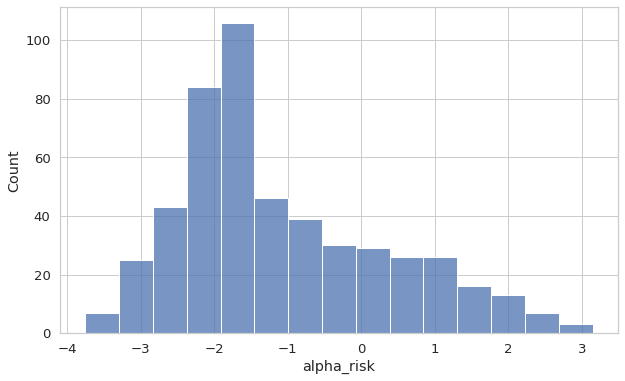

In [41]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(Dataset['alpha_risk'], bins='auto')

plt.ylabel('Count')
plt.show()

### Analyze the data

In [42]:
data_1 = Dataset[Dataset.columns[:n_questions]]
questions = [sum(data_1.iloc[:, i]==1) for i in range(data_1.shape[1])]
print(questions)

[160, 178, 218, 176, 195, 167, 184, 176, 167, 208, 198, 153, 178, 183, 152]


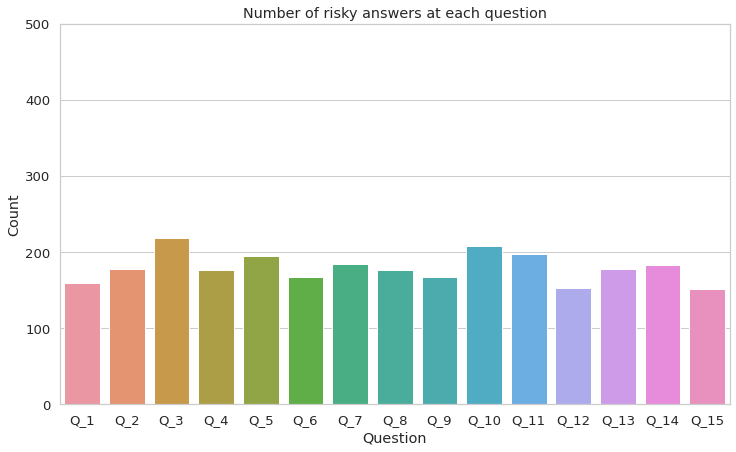

In [43]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))

sns.barplot(x=columns_names[:n_questions], y=questions)

plt.ylim(0,len(data_1))
plt.xlabel('Question')
plt.ylabel('Count')
plt.title('Number of risky answers at each question')
plt.show()

In [44]:
data_sum = data_1.sum(axis=1)

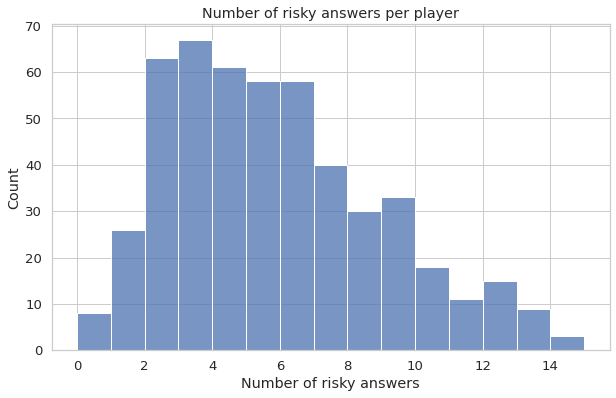

In [45]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(data_sum, bins=n_questions)

plt.xlabel('Number of risky answers')
plt.ylabel('Count')
plt.title('Number of risky answers per player')
plt.show()

## Inference: Bayesian ITR Models

In [14]:
!pip install --upgrade pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install nest-asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import nest_asyncio
nest_asyncio.apply()

In [17]:
model_stan = """
data {
  int<lower=1> J;                     // number of students
  int<lower=1> K;                     // number of questions
  int<lower=1> N;                     // number of observations
  int<lower=1, upper=J> jj[N];  // student for observation n
  int<lower=1, upper=K> kk[N];  // question for observation n
  int<lower=0, upper=1> y[N];   // correctness for observation n
}

parameters {
  real<lower=0, upper=1> mu_beta;     // mean question difficulty
  real<lower=0> sigma_beta;           // scale of difficulties
  real beta[K];                       // difficulty of question k
  real alpha[J];                      // ability of student j
}

model {
  alpha ~ normal(1, 3);   
  beta ~ normal(mu_beta, sigma_beta);                 
  mu_beta ~ cauchy(0, 5);
  sigma_beta ~ cauchy(0, 5);   
  for (n in 1 : N) {
    y[n] ~ bernoulli_logit(alpha[jj[n]] * beta[kk[n]]);
  }
}
"""

In [46]:
import stan

model_stan = """
data {
  int<lower=1> J;                     // number of students
  int<lower=1> K;                     // number of questions
  int<lower=1> N;                     // number of observations
  int<lower=1, upper=J> jj[N];  // student for observation n
  int<lower=1, upper=K> kk[N];  // question for observation n
  int<lower=0, upper=1> y[N];   // correctness for observation n
}

parameters {
  real alpha[J];                      // ability of student j
  real <lower=0, upper=1> beta[K];    // difficulty of question k
}

model {
  alpha ~ normal(-1, 1.5);  // informative true prior
  beta ~ beta(5, 2);     // informative true prior
  for (n in 1 : N) {
    y[n] ~ bernoulli_logit(alpha[jj[n]] * beta[kk[n]]);
  }
}
"""

n_obs = n_players * n_questions

# Create array jj
players_obs = []
for i in range(n_players):
  players_obs.extend([i+1]*n_questions)

# Create array kk
questions_obs = list(range(1, n_questions+1))
questions_obs = questions_obs*n_players

# Create array y
answers_obs = list(data_1.values.flatten())

data_stan = {'J':n_players, 
             'K':n_questions, 
             'N':n_obs, 
             'jj':players_obs, 
             'kk':questions_obs,  
             'y':answers_obs}

posterior = stan.build(model_stan, data=data_stan)
fit = posterior.sample(num_chains=4, num_samples=1000)
#eta = fit["eta"]  # array with shape (8, 4000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1901/8000)
Sampling:  25% (2002/8000)
Sampling:  26% (2101/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/80

In [47]:
df = fit.to_frame() 
df.to_csv('Bayes_Inference.csv')
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,alpha.4,alpha.5,alpha.6,alpha.7,alpha.8,...,beta.1,beta.2,beta.3,beta.4,beta.5,beta.6,beta.7,beta.8,beta.9,beta.10,beta.11,beta.12,beta.13,beta.14,beta.15
draws,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-4625.625198,0.709546,0.294334,4.0,15.0,0.0,4904.965495,-0.579104,-1.582848,-1.737804,-2.250709,1.062232,-2.761439,0.537751,-2.386360,...,0.920421,0.884103,0.382384,0.672105,0.395961,0.769067,0.449595,0.451713,0.677156,0.399937,0.452604,0.951248,0.647112,0.534703,0.760633
1,-4609.120740,1.000000,0.273430,4.0,15.0,0.0,4861.923005,-0.112175,-0.650814,-2.998437,-1.445983,-0.974288,-1.931403,1.453233,-2.542770,...,0.887292,0.811729,0.268875,0.710275,0.445592,0.659120,0.439069,0.593720,0.833517,0.385350,0.341278,0.992673,0.566408,0.564948,0.827244
2,-4637.480961,1.000000,0.260553,4.0,15.0,0.0,4926.189955,0.433969,-1.649180,-2.361500,-0.415754,0.131183,-2.369121,0.565444,-2.839005,...,0.878883,0.713881,0.307042,0.745784,0.471052,0.894911,0.568287,0.552014,0.771352,0.478640,0.466735,0.934040,0.641017,0.493389,0.814573
3,-4627.308344,0.970437,0.267228,4.0,15.0,0.0,4872.908734,-0.745665,0.142627,-3.122824,-1.807012,-0.458551,-2.086604,0.296769,-3.023237,...,0.889897,0.760775,0.266488,0.795640,0.408346,0.814262,0.637904,0.529995,0.885898,0.437169,0.549020,0.852494,0.683722,0.556391,0.896070
4,-4647.531741,0.874022,0.294334,4.0,15.0,0.0,4877.847537,-0.117176,-1.254746,-2.104872,-1.677152,-1.916797,-2.920099,1.267144,-1.592437,...,0.689442,0.767807,0.286406,0.592172,0.436318,0.864515,0.581932,0.612767,0.688753,0.395853,0.512317,0.847484,0.612526,0.592847,0.771629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-4630.067871,0.969547,0.267228,4.0,15.0,0.0,4886.199081,-0.496683,-1.036468,-2.458695,-1.615410,-0.681949,-2.352000,0.420365,-2.560096,...,0.959939,0.713973,0.346109,0.606934,0.478425,0.740843,0.514929,0.510252,0.885447,0.333686,0.530733,0.863213,0.444262,0.494173,0.781595
3996,-4662.591374,0.830675,0.294334,4.0,15.0,0.0,4907.561650,0.012845,-0.062036,-1.317325,-1.748169,-0.604811,-1.244874,0.771686,-1.590509,...,0.910725,0.800004,0.332328,0.642361,0.436634,0.714567,0.551494,0.519898,0.754153,0.344481,0.608833,0.907351,0.666952,0.485339,0.979530
3997,-4651.020140,0.903392,0.273430,4.0,15.0,0.0,4916.271209,0.072273,-0.772598,-2.227599,-0.754307,0.152256,-2.818312,0.426983,-2.848871,...,0.757790,0.776179,0.276520,0.685258,0.397566,0.654444,0.503737,0.506227,0.749889,0.440409,0.535671,0.995562,0.600475,0.450888,0.785443


In [48]:
'''Dataset = pd.read_csv('Data_V3.csv')

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1Q5HsEDdDzOVohsYhp1T6j57VOzpuOCLc', 
                                    dest_path='./data2.csv',
                                    unzip=False)
df = pd.read_csv('data2.csv')
df.drop(columns='draws', inplace=True)
df'''

"Dataset = pd.read_csv('Data_V3.csv')\n\nfrom google_drive_downloader import GoogleDriveDownloader as gdd\n\ngdd.download_file_from_google_drive(file_id='1Q5HsEDdDzOVohsYhp1T6j57VOzpuOCLc', \n                                    dest_path='./data2.csv',\n                                    unzip=False)\ndf = pd.read_csv('data2.csv')\ndf.drop(columns='draws', inplace=True)\ndf"

In [49]:
import arviz as az
summary_posteriors = az.summary(fit)
summary_posteriors

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.066,0.711,-1.489,1.187,0.009,0.012,6759.0,3014.0,1.0
alpha[1],-0.730,0.750,-2.122,0.639,0.008,0.009,7904.0,2611.0,1.0
alpha[2],-2.189,0.857,-3.806,-0.606,0.011,0.009,6956.0,2552.0,1.0
alpha[3],-1.368,0.770,-2.817,0.057,0.009,0.009,6759.0,2789.0,1.0
alpha[4],-0.162,0.737,-1.705,1.102,0.008,0.014,7865.0,2623.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[10],0.471,0.066,0.347,0.591,0.001,0.001,4789.0,3109.0,1.0
beta[11],0.916,0.050,0.826,0.996,0.001,0.001,4245.0,2309.0,1.0
beta[12],0.605,0.076,0.459,0.745,0.001,0.001,4287.0,2515.0,1.0
beta[13],0.536,0.071,0.411,0.674,0.001,0.001,4144.0,2730.0,1.0


### Results

In [50]:
CI = 0.95

In [51]:
means_players_pred = [df.iloc[:,i].mean() for i in range(7,7+n_players)]
# means_players_pred = summary_posteriors['mean'][:500]

y_true = Dataset.loc[:,'alpha_risk']
y_true_profile = Dataset.loc[:,'risk_label']

In [52]:
from collections import Counter

bingos = []
for i in range(1, n_players+1):
  column_name = f'alpha.{i}'
  hdi_low, hdi_up = az.hdi(np.array(df[column_name]), hdi_prob=CI)
  assert hdi_low < hdi_up
  if hdi_low <= y_true[i-1] <= hdi_up:
    bingos.append('CORRECT')
  else:
    bingos.append('ERROR')
count_bingos = Counter(bingos)
print(count_bingos)
acc = count_bingos['CORRECT']/len(bingos)
print(f'Accuracy = {acc:.3f}')

Counter({'CORRECT': 466, 'ERROR': 34})
Accuracy = 0.932


### Plots



Text(0.5, 1.0, 'Posterior density distribution (player 159)')

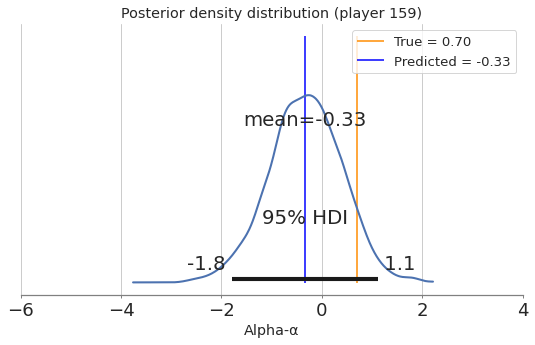

In [53]:
## Example
p = 159
column_name = f'alpha.{p}'
# print(az.hdi(np.array(df[column_name]), hdi_prob=CI))
az.plot_posterior(np.array(df[column_name]), hdi_prob=CI, figsize=(9,5))
x_line = y_true[p-1]
plt.vlines(x=x_line, ymin=0, ymax=0.7, colors=['darkorange'], label=f'True = {x_line:.2f}')
x_line_pred = df[column_name].mean()
plt.vlines(x=x_line_pred, ymin=0, ymax=0.7, colors=['blue'], label=f'Predicted = {x_line_pred:.2f}')
plt.legend(loc='best')
plt.xlabel('Alpha-α')
plt.xlim([-6, 4])
plt.title(f'Posterior density distribution (player {p})')

ERROR


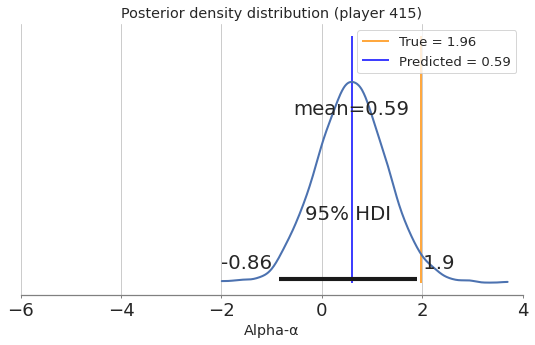

CORRECT


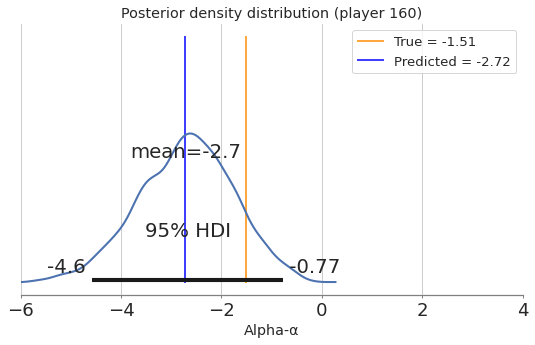

CORRECT


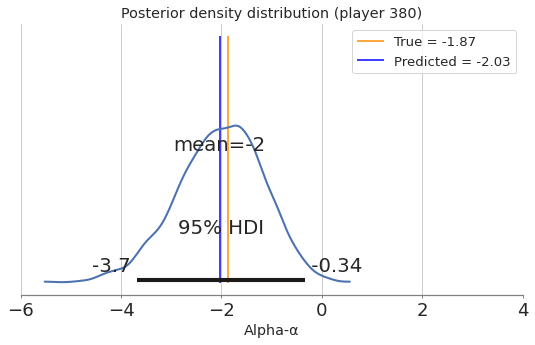

CORRECT


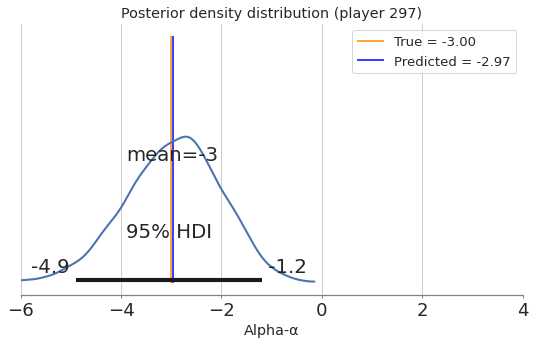

CORRECT


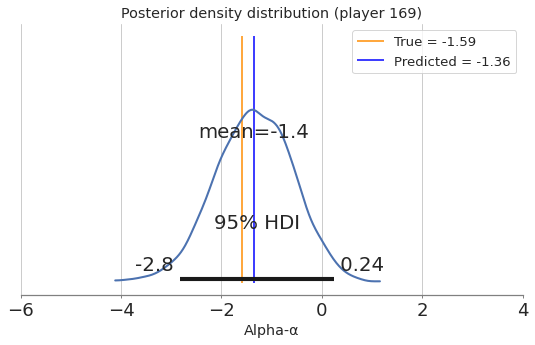

CORRECT


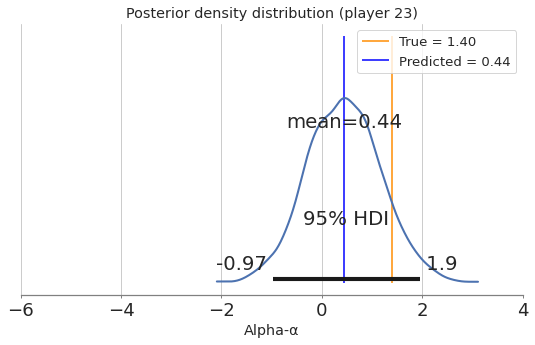

CORRECT


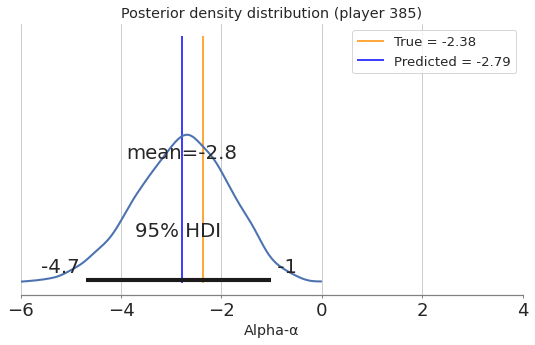

CORRECT


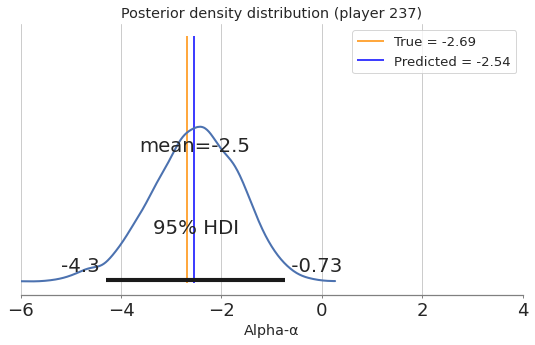

CORRECT


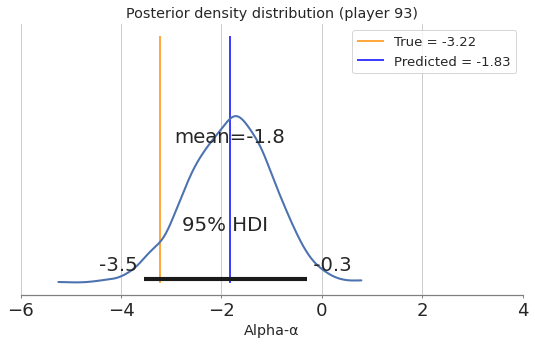

CORRECT


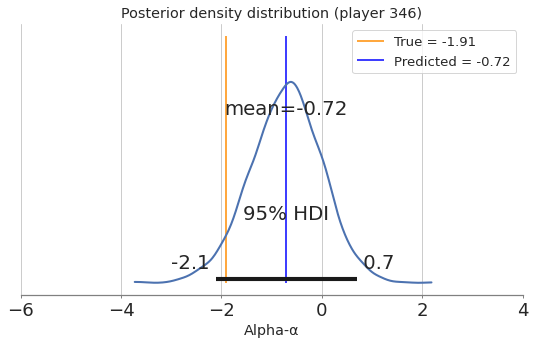

CORRECT


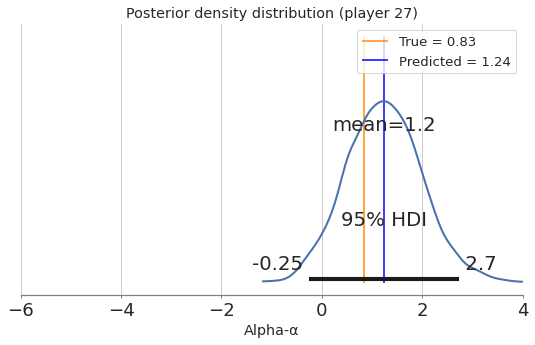

CORRECT


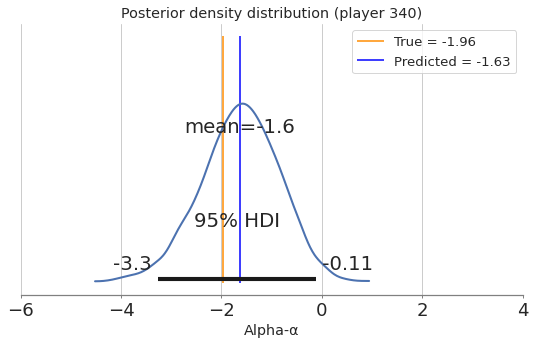

CORRECT


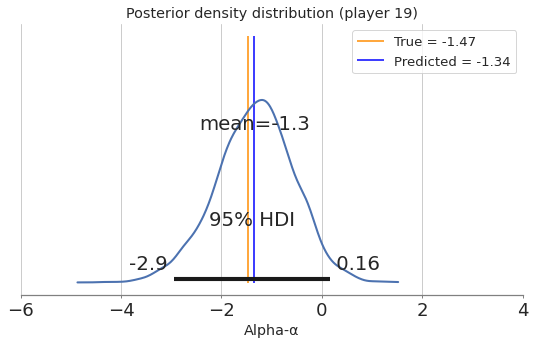

CORRECT


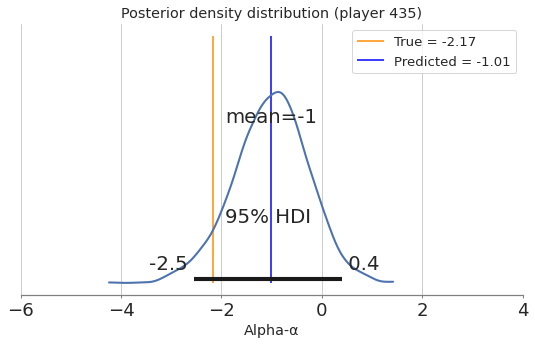

CORRECT


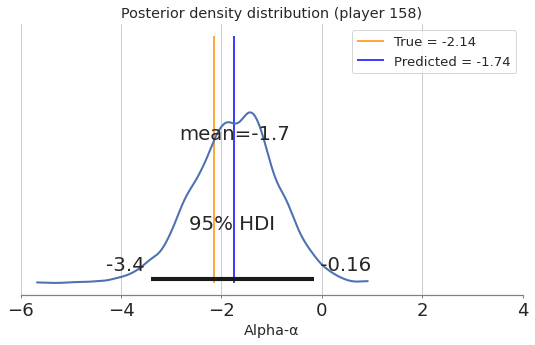

CORRECT


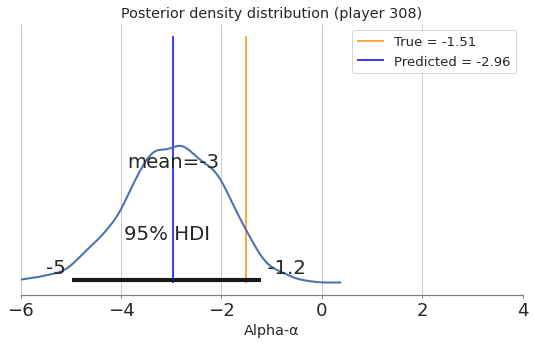

CORRECT


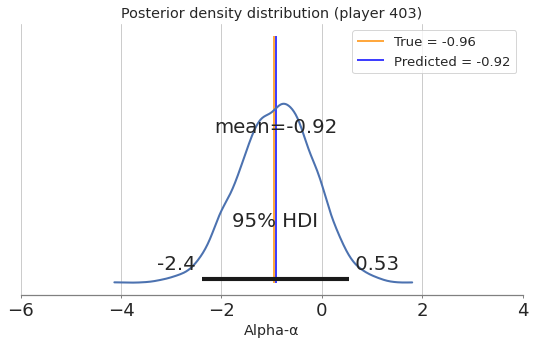

CORRECT


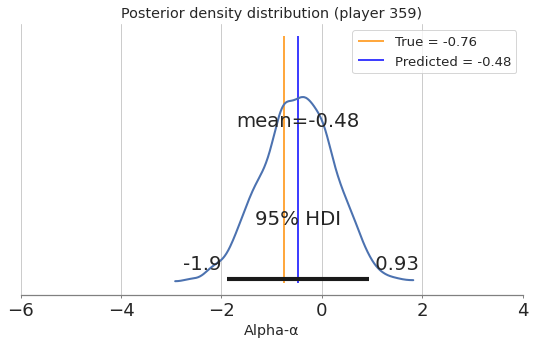

CORRECT


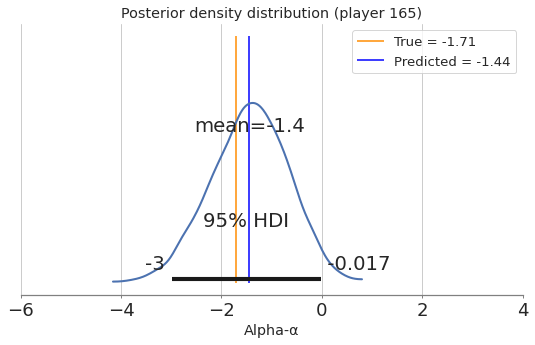

CORRECT


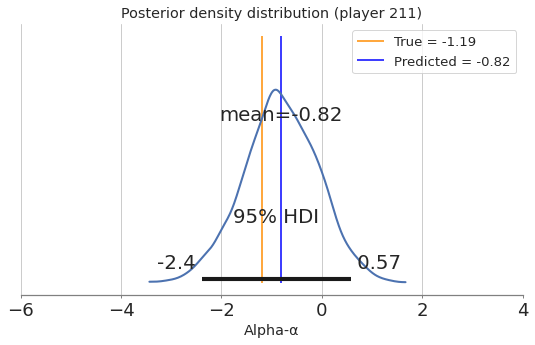

In [54]:
players_plot = np.random.randint(1, n_players+1, size=20)
for i in players_plot:
  
    column_name = f'alpha.{i}'

    hdi_low, hdi_up = az.hdi(np.array(df[column_name]), hdi_prob=CI)
    if hdi_low <= y_true[i-1] <= hdi_up:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')
    # print(hdi_low, hdi_up)
    # print(bingos[i-1])

    az.plot_posterior(np.array(df[column_name]), hdi_prob=CI, figsize=(9,5))
    x_line = y_true[i-1]
    plt.vlines(x=x_line, ymin=0, ymax=0.7, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = df[column_name].mean()
    plt.vlines(x=x_line_pred, ymin=0, ymax=0.7, colors=['blue'], label=f'Predicted = {x_line_pred:.2f}')
    plt.legend(loc='best')
    plt.xlabel('Alpha-α')
    plt.xlim([-6, 4])
    plt.title(f'Posterior density distribution (player {i})')
    plt.grid(True)
    plt.show()

CORRECT


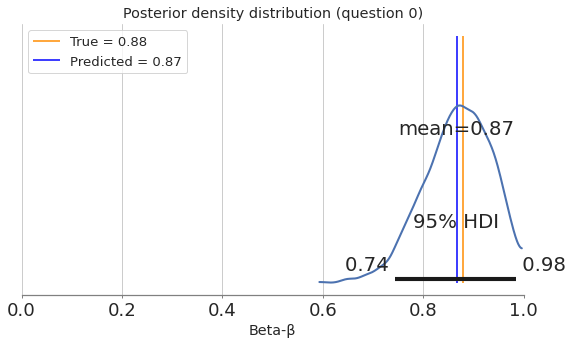

ERROR


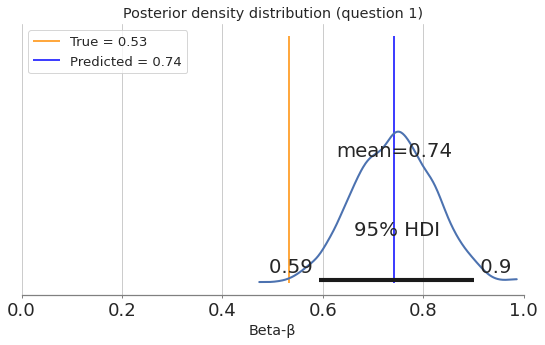

CORRECT


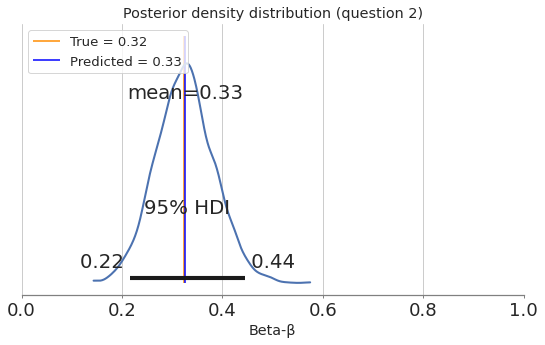

CORRECT


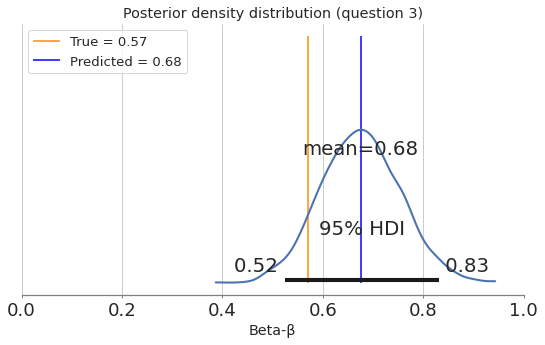

ERROR


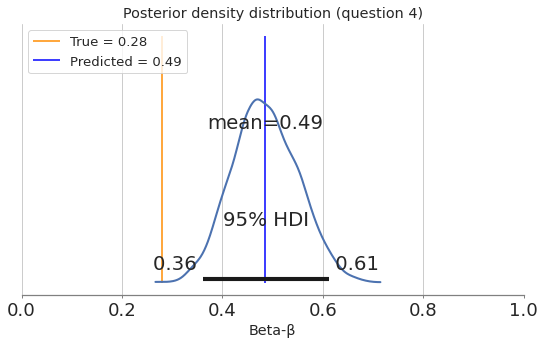

CORRECT


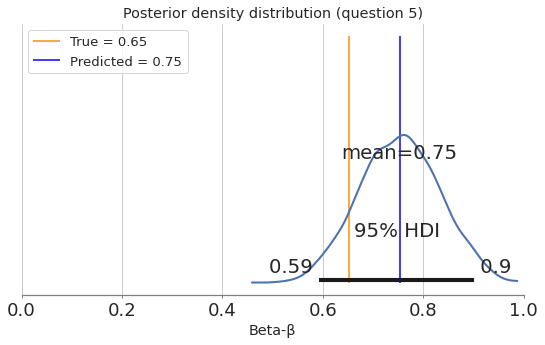

CORRECT


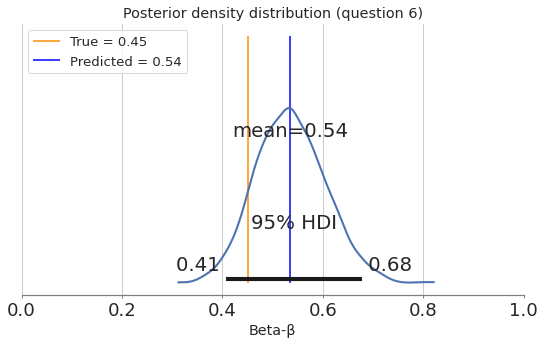

CORRECT


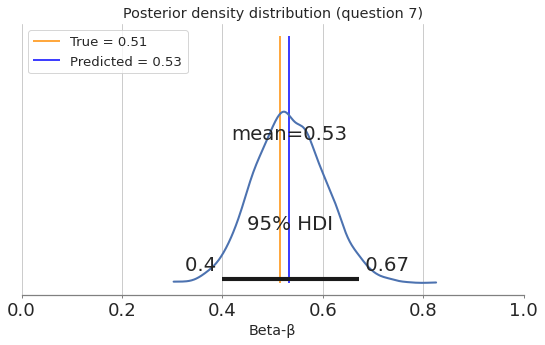

CORRECT


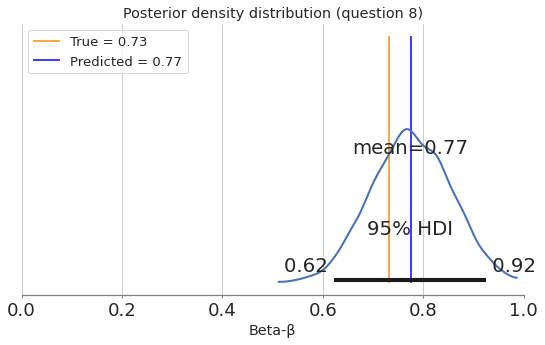

CORRECT


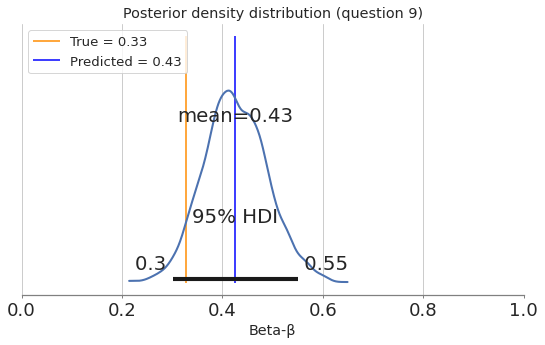

CORRECT


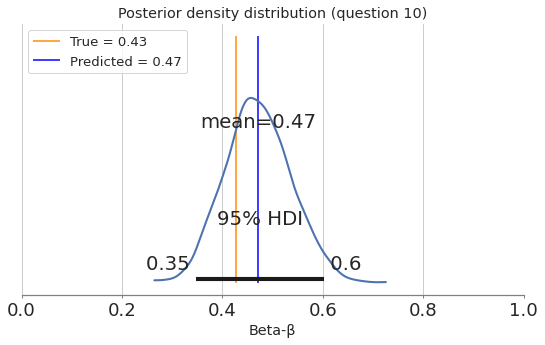

CORRECT


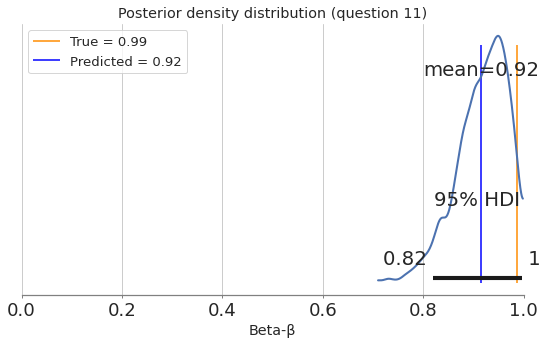

CORRECT


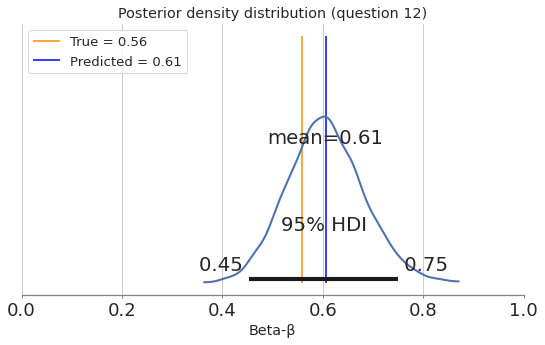

CORRECT


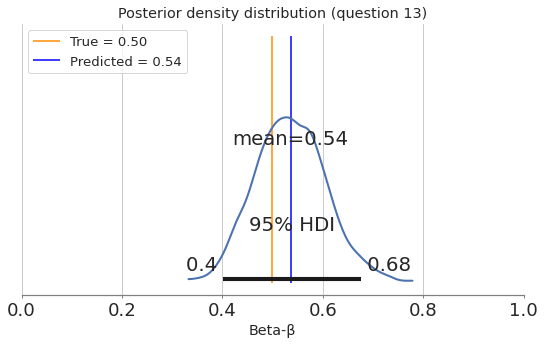

ERROR


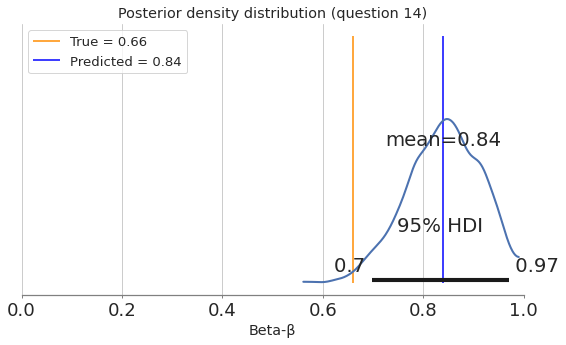

In [55]:
for i in range(n_questions):
    # difficulty
    difficulty = game_1.difficulty_questions[i]

    column_name = f'beta.{i+1}'

    hdi_low, hdi_up = az.hdi(np.array(df[column_name]), hdi_prob=CI)
    if hdi_low <= difficulty <= hdi_up:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')

    az.plot_posterior(np.array(df[column_name]), hdi_prob=CI, figsize=(9,5))
    x_line = difficulty
    plt.vlines(x=x_line, ymin=0, ymax=8, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = df[column_name].mean()
    plt.vlines(x=x_line_pred, ymin=0, ymax=8, colors=['blue'], label=f'Predicted = {x_line_pred:.2f}')
    plt.legend(loc='upper left')
    plt.xlim([0, 1])
    plt.xlabel('Beta-β')
    plt.title(f'Posterior density distribution (question {i})')
    plt.grid(True)
    plt.show()